# full exp:
- gridsearch blocked/interleaved, using MSE human as eval metric
    - fix parameters
- eval fit on early/middle/late conditions

# handheld splitting, RNN schema

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import zscore
from utils import *
import pandas as pd
from glob import glob as glob

In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### experiment funs

In [3]:
def run_exp(nseeds,condL,paramD,ntr=160,nte=40):
    """ returns acc for cond in condL """
    print('N=%i'%nseeds,paramD)
    acc = -np.ones([len(condL),nseeds,ntr+nte])
    for ci,cond in enumerate(condL):
        for s in range(nseeds):
            # seed ctrl
            np.random.seed(s)
            tr.manual_seed(s)
            # init
            ag = Agent(**paramD)
            task = Task()
            # run
            exp,cur = task.generate_experiment(cond,ntr,nte)
            acc[ci,s] = ag.forward_exp(exp) 
    return acc

  
def calc_fit(accL,condL):
    """ 
    accL is arr [cond,seed,trials]
    NOTE: CURRENTLY FITTING ON ZSCORED
    calcualte mean squared error for model fit
    returns mse per condition
    """
    MSE = 0
    for model_acc,cond in zip(accL,condL):
        human_acc = human_accD[cond]
        # mean over seeds -> [trials]
        model_acc = model_acc.mean(0) 
        # zscore
        model_zacc = zscore(model_acc)
        human_zacc = zscore(human_acc)
        # mse
        MSE += np.sum((human_zacc - model_zacc)**2)
    return MSE


### load gridsearch results

In [4]:
##  load human data for fitting
humandf = pd.read_csv('humandf.csv')
human_accD = {}
condL =['blocked','interleaved','early','middle','late']
for cond in condL:
    human_accD[cond] = humandf.loc[:,'%s mean'%cond].values
# 1d arrs of acc
human_accD['blocked'].shape,human_accD.keys()

((200,), dict_keys(['blocked', 'interleaved', 'early', 'middle', 'late']))

In [5]:
## load grdisearch model data
gs_results = []
for fname in glob('gsdata/*'):
  paramk = ['sticky_decay','pe_thresh','init_lr','lr_decay','stsize']
  paramv = [float(i.split('_')[-1]) for i in fname.split('.npy')[0].split('-')]
  acc = np.load(fname)
  paramD = dict(zip(paramk,paramv))
  mse = calc_fit(acc,['blocked','interleaved'])
  gs_results.append({**paramD,'mse':mse})

In [6]:
## find best fit model
bestparamD = pd.DataFrame(gs_results
              ).sort_values('mse'
              ).iloc[0].to_dict()
bestparamD.pop('mse')
bestparamD

{'sticky_decay': 0.025,
 'pe_thresh': 1.0,
 'init_lr': 0.25,
 'lr_decay': 0.05,
 'stsize': 10.0}

# analysis of best fit

In [7]:
def plt_human(ax=None,condL=['blocked'],c='k'):
  for cond in condL:
    ax.plot(human_accD[cond],
            c=c,zorder=-99,alpha=0.4
           )
  return None

def plt_acc(acc,condL,ax=None,h=1):
  # model
  for ac in acc:
    ax.plot(ac.mean(0))
  # human plot
  if h:
    plt_human(ax=ax,condL=condL)
  ax.set_ylim(0.2,1)    
  return None

### blocked / interleaved plots

In [8]:
ns = 10
condBI = ['blocked','interleaved']
acc_bestBI = run_exp(nseeds=ns,
              condL=condBI,
              paramD=bestparamD
             )

N=10 {'sticky_decay': 0.025, 'pe_thresh': 1.0, 'init_lr': 0.25, 'lr_decay': 0.05, 'stsize': 10.0}


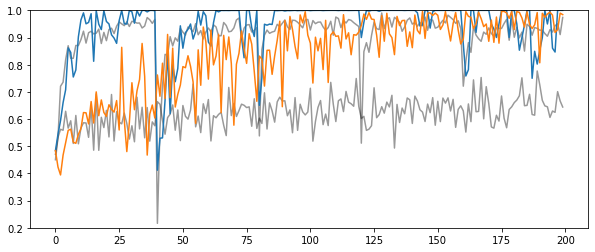

In [9]:
plt.subplots(figsize=(10,4))
ax = plt.gca()
plt_acc(acc_bestBI,condBI,ax=ax)

### early / middle / late plots

In [10]:
condEML=['early','middle','late']
ns = 10
acc_bestEML = run_exp(nseeds=ns,
              condL=condEML,
              paramD=bestparamD
             )

N=10 {'sticky_decay': 0.025, 'pe_thresh': 1.0, 'init_lr': 0.25, 'lr_decay': 0.05, 'stsize': 10.0}


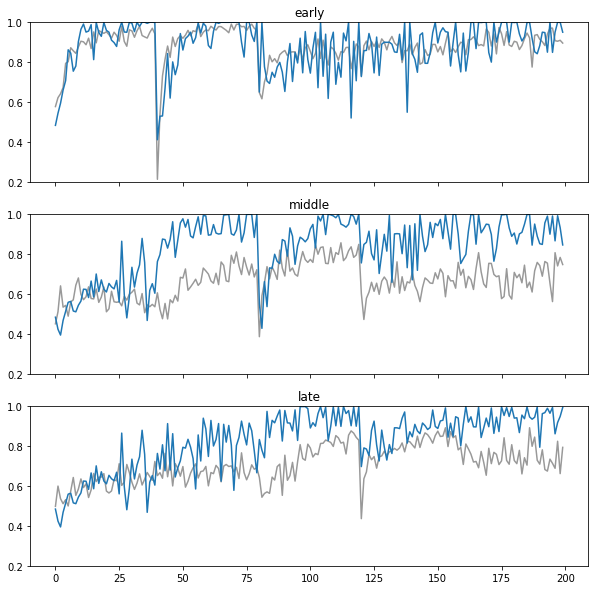

In [11]:
f,ax = plt.subplots(3,1,figsize=(10,10),sharex=True)
for ci in range(3):
  cond = condEML[ci]
  plt_acc([acc_bestEML[ci]],[cond],ax=ax[ci])
  ax[ci].set_title(cond)